In [34]:
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError, MeanAbsoluteError
import torch
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    BlockRNNModel,
    TFTModel
)
from darts.explainability.tft_explainer import TFTExplainer
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)
import csv

In [35]:
gdpnow = pd.read_csv('train_set.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
# Ensure that load_df index is in the same date format
gdpnow.index = pd.to_datetime(gdpnow.index)

In [36]:
start_date = '2014-05-01'
end_date = '2024-01-19'

In [37]:
gdpnow.columns

Index(['value_CCLACBW027SBOG', 'value_WTISPLC', 'value_EXPINF1YR',
       'value_STLPPM', 'value_M2REAL', 'value_UNRATE', 'value_PPIACO',
       'value_PCUOMFGOMFG', 'value_PCUATRANSATRANS', 'value_PCUATRADEATRADE',
       'value_PCUAWHLTRAWHLTR', 'value_CSUSHPINSA', 'value_SPCS20RSA',
       'value_WALCL', 'value_REAINTRATREARAT10Y', 'value_SAHMREALTIME',
       'value_POPTHM', 'value_CES0500000003', 'value_NFCI', 'value_WEI',
       'value_ICSA', 'value_ADPWNUSNERSA', 'value_FEDFUNDS',
       'value_CORESTICKM159SFRBATL', 'value_CPIAUCSL', 'value_PAYEMS',
       'value_MORTGAGE30US', 'USGGBE02 Index', 'USOSFR10 Curncy', 'CL1 Comdty',
       'USOSFR2 Curncy', 'NDX Index ', 'SPX Index ', 'USDJPY Curncy',
       'GSUSFCI Index', 'CESIUSD Index', 'Monthly Nominal GDP Index',
       'Monthly Real GDP Index', 'Advance Estimate From BEA',
       'Business Fixed Investment',
       'Change in inventory investment ($Bil 2009)',
       'Change in net exports ($Bil 2009)',
       'Current chang

In [38]:
#Target S&P
Target = 'SPX Index '
# SPX Index remains!
Drop = ['value_CCLACBW027SBOG', 'value_WTISPLC', 'value_EXPINF1YR',
       'value_STLPPM', 'value_M2REAL', 'value_UNRATE', 'value_PPIACO',
       'value_PCUOMFGOMFG', 'value_PCUATRANSATRANS', 'value_PCUATRADEATRADE',
       'value_PCUAWHLTRAWHLTR', 'value_CSUSHPINSA', 'value_SPCS20RSA',
       'value_WALCL', 'value_REAINTRATREARAT10Y', 'value_SAHMREALTIME',
       'value_POPTHM', 'value_CES0500000003', 'value_NFCI', 'value_WEI',
       'value_ICSA', 'value_ADPWNUSNERSA', 'value_FEDFUNDS',
        'value_PAYEMS',
        'USGGBE02 Index', 'USOSFR10 Curncy',
       'USOSFR2 Curncy', 'USDJPY Curncy',
       'Monthly Nominal GDP Index',
       'Monthly Real GDP Index', 'Advance Estimate From BEA',
       'Business Fixed Investment',
       'Change in inventory investment ($Bil 2009)',
       'Change in net exports ($Bil 2009)',
       'Current change in private inventories ($Bil 2009)', 'Data releases',
       'Days until advance estimate', 'Equipment', 'Exports', 'Federal Govt',
       'Final Sales', 'Final Sales to Domestic Purchasers',
       'Final Sales to Private Domestic Purchasers', 'Final_GDP_Interp',
       'Fixed Investment', 'Forecast Error', 'GPDI',
       'Goods exports', 'Goods imports', 'Government', 'Imports',
       'Intellectual Property Products', 'Net Exports (current, $Bil 2009)',
       'Net Exports (previous, $Bil 2009)', 'PCE', 'PCE Goods', 'PCE Services',
       'Previous change in private inventories ($Bil 2009)',
       'Publication Date of Advance Estimate', 'Quarter being forecasted',
       'Residential', 'S&L', 'Services exports', 'Services imports',
       'Structures']

In [39]:
gdpnow = gdpnow.drop(columns=Drop)

In [40]:
timeseries = TimeSeries.from_dataframe(gdpnow, freq='D')

In [41]:
from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ts_transformer = Scaler(scaler)
target_transformer = Scaler(scaler)

scaled_ts = ts_transformer.fit_transform(timeseries)
target_transformer = target_transformer.fit(timeseries[Target])

In [42]:
scaled_ts

<TimeSeries (DataArray) (Dates: 3551, component: 9, sample: 1)> Size: 256kB
array([[[0.14149589],
        [0.02897062],
        [0.31906615],
        ...,
        [0.43815514],
        [0.27900818],
        [0.63546256]],

       [[0.14149589],
        [0.02897062],
        [0.31906615],
        ...,
        [0.4360587 ],
        [0.3025999 ],
        [0.63876652]],

       [[0.14149589],
        [0.02897062],
        [0.31906615],
        ...,
...
        ...,
        [0.54297694],
        [0.35146846],
        [0.61894273]],

       [[0.62351188],
        [1.        ],
        [0.76848249],
        ...,
        [0.53668763],
        [0.35989408],
        [0.61894273]],

       [[0.62351188],
        [1.        ],
        [0.76848249],
        ...,
        [0.51991614],
        [0.38059701],
        [0.61894273]]])
Coordinates:
  * Dates      (Dates) datetime64[ns] 28kB 2014-05-01 2014-05-02 ... 2024-01-19
  * component  (component) object 72B 'value_CORESTICKM159SFRBATL' ... 'GDP N...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [43]:
from darts.utils.missing_values import fill_missing_values
scaled_ts = fill_missing_values(scaled_ts)
scaled_ts

<TimeSeries (DataArray) (Dates: 3551, component: 9, sample: 1)> Size: 256kB
array([[[0.14149589],
        [0.02897062],
        [0.31906615],
        ...,
        [0.43815514],
        [0.27900818],
        [0.63546256]],

       [[0.14149589],
        [0.02897062],
        [0.31906615],
        ...,
        [0.4360587 ],
        [0.3025999 ],
        [0.63876652]],

       [[0.14149589],
        [0.02897062],
        [0.31906615],
        ...,
...
        ...,
        [0.54297694],
        [0.35146846],
        [0.61894273]],

       [[0.62351188],
        [1.        ],
        [0.76848249],
        ...,
        [0.53668763],
        [0.35989408],
        [0.61894273]],

       [[0.62351188],
        [1.        ],
        [0.76848249],
        ...,
        [0.51991614],
        [0.38059701],
        [0.61894273]]])
Coordinates:
  * Dates      (Dates) datetime64[ns] 28kB 2014-05-01 2014-05-02 ... 2024-01-19
  * component  (component) object 72B 'value_CORESTICKM159SFRBATL' ... 'GDP N...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [44]:
train, val = (scaled_ts).split_before(0.9)

In [45]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=30,
    min_delta=0.005,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper],
                   "accelerator": "cpu"}

In [46]:
# predict 15 days considering the latest 45 days
input_chunk_length=45
output_chunk_length=7


model_pastcov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    dropout=0.2,
    torch_metrics=MeanAbsoluteError(),
    n_epochs=100,
    pl_trainer_kwargs = pl_trainer_kwargs,
    random_state=0#,
    #hidden_dim=40, n_rnn_layers=15
)

In [47]:
model_pastcov.fit(
    series=[train[Target]],    # the target training data
    past_covariates=train,     # the multi covariate features training data
    val_series=[val[Target]],  # the target validation data
    val_past_covariates=val,   # the multi covariate features validation data
    verbose=True,
)

Epoch 0:   0%|          | 0/99 [00:00<?, ?it/s]                             

Epoch 30: 100%|██████████| 99/99 [00:01<00:00, 72.68it/s, train_loss=0.000239, val_loss=0.002, val_MeanAbsoluteError=0.0368, train_MeanAbsoluteError=0.0132]  


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.2, input_chunk_length=45, output_chunk_length=7, torch_metrics=MeanAbsoluteError(), n_epochs=100, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x2b1a20b80>], 'accelerator': 'cpu'}, random_state=0)

In [48]:
temp = model_pastcov.predict(n=1,                        # n of days to predict
                                    series=val[Target][:input_chunk_length],  # target input for prediction
                                    past_covariates=val[:input_chunk_length])

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 197.17it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.95it/s]

<Axes: xlabel='Dates'>

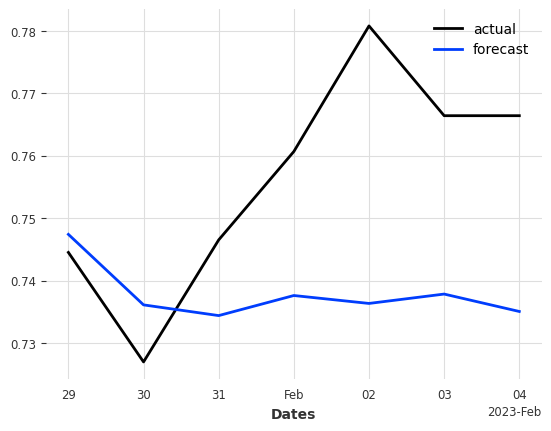

In [49]:
pred_cov = model_pastcov.predict(n=7,                        # n of days to predict
                                 series=train[Target][-45:],  # target input for prediction
                                 past_covariates=train[-45:]) # past-covariates input for prediction

val[:7][Target].plot(label="actual")
pred_cov.plot(label="forecast")

In [50]:
df_validation = {'s&p':y_real, 'prediction':y_pred}
df_validation = pd.DataFrame(df_validation)
df_validation

,s&p,prediction
0,3960.28,3899.957863
1,3916.64,3881.780680
2,3916.64,3843.688763
3,3916.64,3811.181585
4,3951.57,3792.805101
...,...,...
305,4783.83,4108.057787
306,4765.98,4119.539017
307,4739.21,4129.173332
308,4780.94,4138.621623


In [51]:
df_validation['predicted delta'] = 0
df_validation['real delta'] = 0

for i in range(len(df_validation)-1):
    df_validation['predicted delta'].iloc[i] = \
        df_validation['prediction'].iloc[i+1] \
        -df_validation['prediction'].iloc[i]

    df_validation['real delta'].iloc[i] = \
        df_validation['s&p'].iloc[i+1] \
        -df_validation['s&p'].iloc[i]

df_validation


,s&p,prediction,predicted delta,real delta
0,3960.28,3899.957863,-18.177183,-43.64
1,3916.64,3881.780680,-38.091917,0.00
2,3916.64,3843.688763,-32.507179,0.00
3,3916.64,3811.181585,-18.376484,34.93
4,3951.57,3792.805101,3.837421,51.30
...,...,...,...,...
305,4783.83,4108.057787,11.481230,-17.85
306,4765.98,4119.539017,9.634314,-26.77
307,4739.21,4129.173332,9.448291,41.73
308,4780.94,4138.621623,9.164637,58.87


In [55]:
def istrue(row):
    my_bool = None
    if row['real delta'] != 0:
        my_bool =  (row['real delta'] > 0 and row['predicted delta'] > 0) \
            or (row['real delta'] < 0 and row['predicted delta'] < 0)

    return my_bool

df_validation['direction_right'] = df_validation.apply(istrue, axis=1)

In [56]:
df_validation.direction_right.value_counts()

True     107
False    105
Name: direction_right, dtype: int64

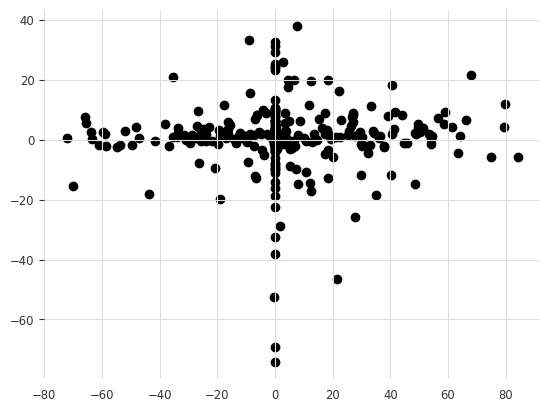

In [57]:
plt.scatter(df_validation['real delta'], df_validation['predicted delta'])